In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os as os

import time as time
import seaborn as sns
import glob as glob

from scipy import stats
from scikit_posthocs import posthoc_tukey
from itertools import combinations
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from statannotations.Annotator import Annotator
import itertools as itls
%matplotlib inline

In [2]:
sampinfo=pd.read_csv('Count.csv',index_col=0)
deseqsampinfo=pd.read_csv('Sample_Info.csv',index_col=0)
nondeseq=[x for x in sampinfo.index.tolist() if x not in deseqsampinfo.index.tolist()]
sampinfo.loc[nondeseq,"Remove"]='Yes'

In [3]:
### Separates out the different sample types for further inspections and then lists the comparable samples##
gpcol='G4'
sampcols=sampinfo.columns.tolist()
synlist=[x for x in sampcols if 'SynCom' in x]
sumlist=[x for x in sampcols if 'Sum' in x]
sumlist=sumlist[1:]
fraclist=[x for x in sampcols if 'Frac' in x]
sampgrps=sampinfo[[gpcol,'Remove']]

grouplist=np.sort(list(set(sampinfo[gpcol].tolist())))
for ddx,gpl in enumerate(grouplist):
    print(ddx,gpl)

0 Attached sand_EcoFAB_Brachypodium_No_N_21_21
1 Attached sand_EcoFAB_Brachypodium_No_N_24_21
2 Attached sand_EcoFAB_Brachypodium_No_N_29_21
3 Attached sand_EcoFAB_Brachypodium_Yes_0_14_14
4 Attached sand_EcoFAB_Brachypodium_Yes_0_21_21
5 Attached sand_EcoFAB_Brachypodium_Yes_3_14_11
6 Attached sand_EcoFAB_Brachypodium_Yes_3_24_21
7 Attached sand_EcoFAB_Brachypodium_Yes_8S_29_21
8 Attached sand_EcoFAB_Brachypodium_Yes_8_14_6
9 Attached sand_EcoFAB_Brachypodium_Yes_8_29_21
10 Root_EcoFAB_Brachypodium_No_N_21_21
11 Root_EcoFAB_Brachypodium_No_N_24_21
12 Root_EcoFAB_Brachypodium_No_N_29_21
13 Root_EcoFAB_Brachypodium_Yes_0_14_14
14 Root_EcoFAB_Brachypodium_Yes_0_21_21
15 Root_EcoFAB_Brachypodium_Yes_3_14_11
16 Root_EcoFAB_Brachypodium_Yes_3_24_21
17 Root_EcoFAB_Brachypodium_Yes_8S_29_21
18 Root_EcoFAB_Brachypodium_Yes_8_14_6
19 Root_EcoFAB_Brachypodium_Yes_8_29_21
20 SynCom mix_liquid_None_Yes_0_0_0
21 nan
22 unattached sand_EcoFAB_Brachypodium_No_N_21_21
23 unattached sand_EcoFAB_Brachyp

In [4]:
### Select 21DPI samples
selset=[26,28,31,4,6,9,14,16,19]
compgrps=grouplist[selset]
selgrps=sampgrps[(sampgrps[gpcol].isin(compgrps))]
selgrps.sort_values(gpcol)

namecols=[]
remlist=selgrps['Remove'].tolist()
for rml in remlist:
    if rml=='Yes':
        namecols.append('r')
    else:
        namecols.append('k')

In [5]:
### This melt all the samples with the same Type into one group for plotting
selgrps = selgrps.rename({'G4': 'name'}, axis=1)
selgrps = selgrps.join(selgrps['name'].str.split(pat= "_", n = 1, expand=True).rename(columns={0:'G4', 1:'rem'}))
selgrps
meta = selgrps['G4'].tolist()

In [6]:
# Select sumplot, then calculate samples by group (G4)
sumplot=sampinfo.loc[selgrps.index.tolist(),sumlist]
avgsumplot=pd.concat([sumplot, selgrps], axis=1)
selavgs = avgsumplot.groupby([gpcol, 'Remove'], dropna=False)[sumlist].mean().reset_index()
selavgs[['Remove']] = selavgs[['Remove']].fillna('')
selavgs['combined_name'] =  selavgs[gpcol] + selavgs['Remove']

### Re-listing samples the samples for convenience
selgrouplist=np.sort(list(set(selavgs[gpcol].tolist())))
for ddx,gpl in enumerate(selgrouplist):
    print(ddx,gpl)

0 Attached sand
1 Root
2 unattached sand


In [7]:
# Select synplot, then calculate samples by group (G4)
synplot=sampinfo.loc[selgrps.index.tolist(),synlist]
avgsynplot=pd.concat([synplot, selgrps], axis=1)
selsynavgs = avgsynplot.groupby([gpcol, 'Remove'], dropna=False)[synlist].mean().reset_index()
selsynavgs[['Remove']] = selsynavgs[['Remove']].fillna('')
selsynavgs['combined_name'] =  selsynavgs[gpcol] + selsynavgs['Remove']

### Re-listing samples the samples for convenience
selsynavggrouplist=np.sort(list(set(selsynavgs[gpcol].tolist())))
for ddx,gpl in enumerate(selsynavggrouplist):
    print(ddx,gpl)
levels=[2,0,1]
selsynavgs = selsynavgs.reindex(levels) 
selsynavgs

0 Attached sand
1 Root
2 unattached sand


,G4,Remove,SynCom17_Burkholderia_sp._OAS925,SynCom17_Rhizobium_sp._OAE497,SynCom17_Mucilaginibacter_sp._OAE612,SynCom17_Variovorax_sp._OAS795,SynCom17_Rhodococcus_sp._OAS809,SynCom17_Methylobacterium_sp._OAE515,SynCom17_Lysobacter_sp._OAE881,SynCom17_Bacillus_sp._OAE603,SynCom17_Niastella_sp._OAS944,SynCom17_Bosea_sp._OAE506,SynCom17_Paenibacillus_sp._OAE614,SynCom17_Chitinophaga_sp._OAE865,SynCom17_Arthrobacter_sp._OAP107,SynCom17_Brevibacillus_sp._OAP136,SynCom17_Bradyrhizobium_sp._OAE829,SynCom17_Mycobacterium_sp._OAE908,combined_name
2,unattached sand,,989.578947,291.421053,554.578947,1244.210526,20.210526,47.421053,13.263158,0.578947,5.105263,11.526316,0.000000,5.315789,0.421053,1.000000,0.0,0.0,unattached sand
0,Attached sand,,2495.526316,1083.684211,640.000000,540.578947,153.368421,48.842105,48.684211,0.684211,8.578947,16.210526,0.263158,21.263158,0.684211,0.526316,1.0,0.0,Attached sand
1,Root,,388.055556,40.000000,2.444444,6.888889,0.833333,8.222222,17.888889,0.944444,0.000000,1.055556,0.000000,0.000000,0.500000,0.000000,0.0,0.0,Root


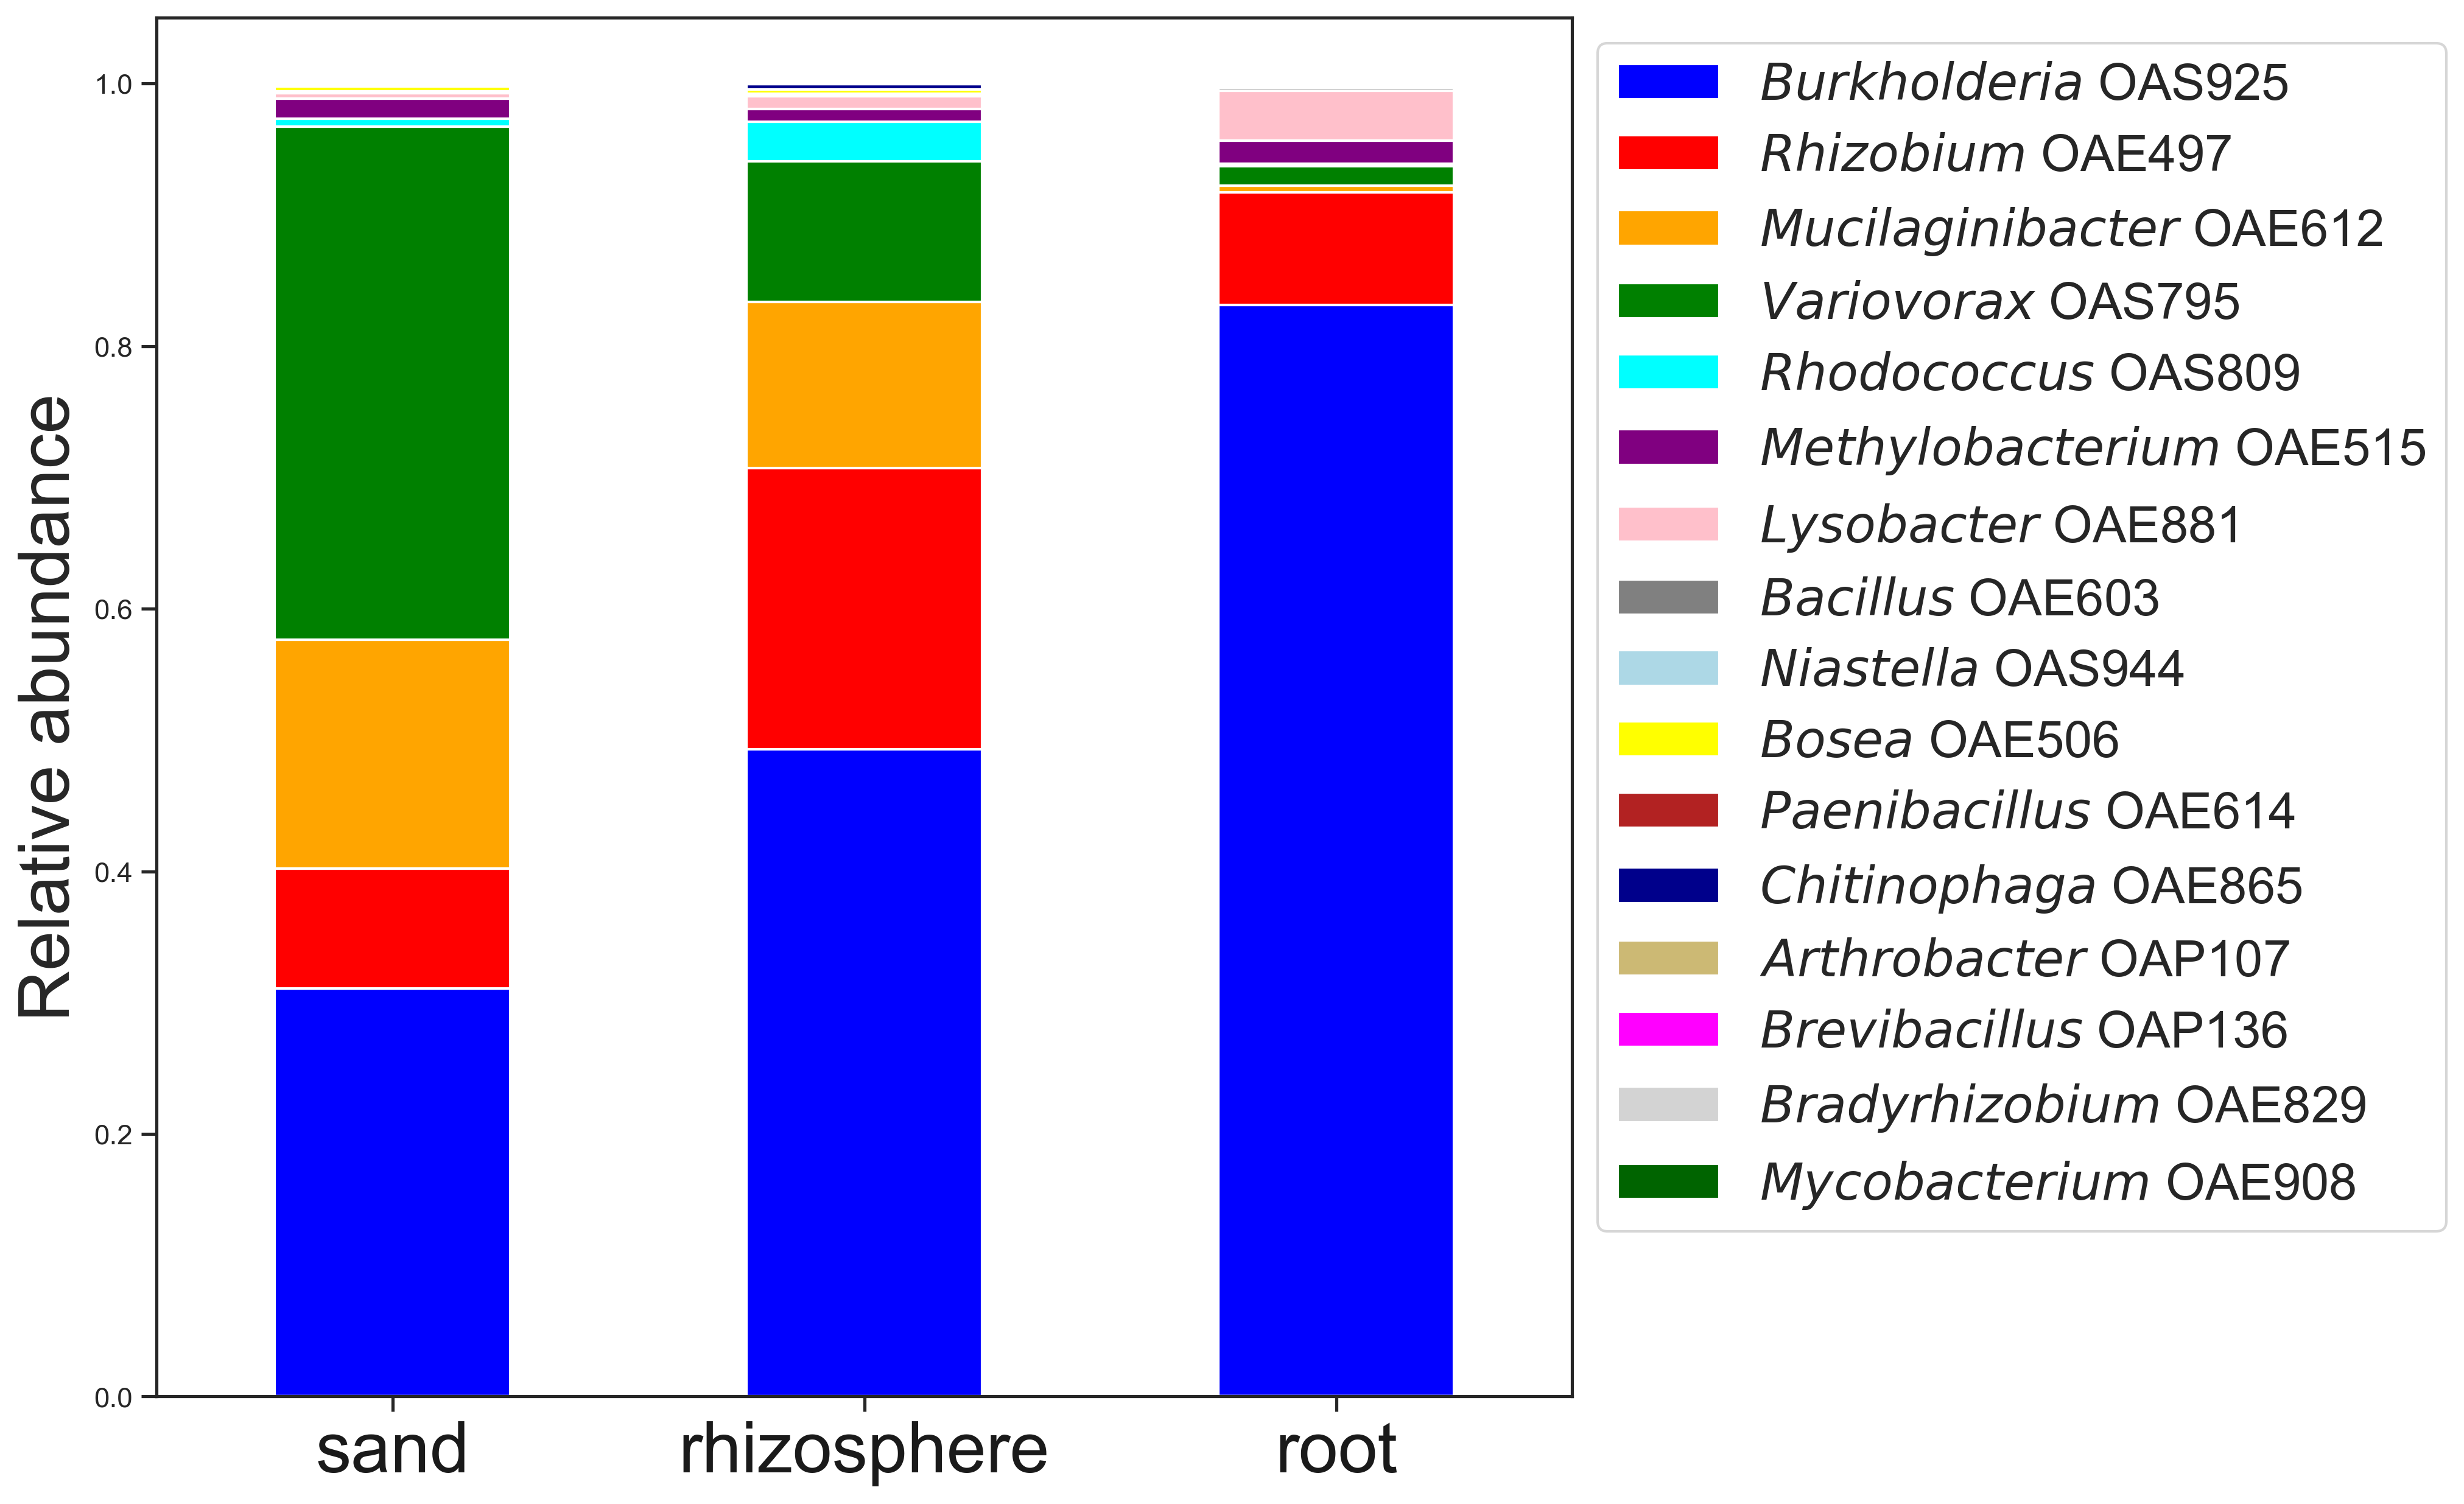

In [8]:
### This generates the relative abundance plot based on group
fig_labels = ['$\it{Burkholderia}$ OAS925', '$\it{Rhizobium}$ OAE497', '$\it{Mucilaginibacter}$ OAE612',
       '$\it{Variovorax}$ OAS795', '$\it{Rhodococcus}$ OAS809', '$\it{Methylobacterium}$ OAE515',
       '$\it{Lysobacter}$ OAE881', '$\it{Bacillus}$ OAE603', '$\it{Niastella}$ OAS944',
       '$\it{Bosea}$ OAE506', '$\it{Paenibacillus}$ OAE614', '$\it{Chitinophaga}$ OAE865',
       '$\it{Arthrobacter}$ OAP107', '$\it{Brevibacillus}$ OAP136', '$\it{Bradyrhizobium}$ OAE829',
       '$\it{Mycobacterium}$ OAE908']
syncolors=['blue','red','orange','green','cyan','purple','pink','grey','lightblue','yellow','firebrick','darkblue','y','magenta','lightgray','darkgreen']

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
synplot3=selsynavgs[synlist].T/selsynavgs[synlist].T.sum(axis=0)
synplot3=synplot3.T
ax=synplot3.plot.bar(stacked=True, figsize=(10, 10),color=syncolors)
ax.legend(labels = fig_labels,
          bbox_to_anchor=(1.0, 1.0), fontsize = 20)

x_name = ["sand", "rhizosphere", "root"]
ax.set_xticklabels(x_name, fontsize = 28, rotation=0)
ax.set_ylabel('Relative abundance', fontsize = 28)
for ticklabel, tickcolor in zip(ax.get_xticklabels(), namecols):
    ticklabel.set_color(tickcolor)